## Assignment 2 —  Embeddings from Language Models 

Author: Danis Alukaev <br>
Email: d.alukaev@innopolis.university <br>
Group: B19-DS-01

### ELMo: Embeddings from Language Models 
![](https://get.whotrades.com/u4/photoDE6C/20647654315-0/blogpost.jpeg)

In this assignment you will implement a deep lstm-based model for contextualized word embeddings - ELMo. Your tasks are as following: 

- Preprocessing (20 points)
- Implementation of ELMo model (30 points)
  - 2-layer BiLSTM (15 points)
  - Highway layers (5 points) [link](https://paperswithcode.com/method/highway-layer) [paper](https://arxiv.org/pdf/1507.06228.pdf) [code](https://github.com/allenai/allennlp/blob/9f879b0964e035db711e018e8099863128b4a46f/allennlp/modules/highway.py#L11)
  - CharCNN embeddings (10 points) [paper](https://arxiv.org/pdf/1509.01626.pdf)
- Report metrics and loss using tensorbord/comet or other tool.  (10 points)
- Evaluate on movie review dataset (20 pts)
- Compare the performance with BERT model (10 pts)
- Clean and documented code (10 points)


Remarks: 

*   Use Pytorch
*   Cheating will result in 0 points


ELMo paper: https://arxiv.org/pdf/1802.05365.pdf

Possible datasets:
- [WikiText-103](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/)
- Any monolingual dataset from [WMT](https://statmt.org/wmt22/translation-task.html)

## Prerequisites

Make sure that all necessary dependencies are installed and CUDA 10.2 is available
```
$ pip install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu102
$ pip install torchtext==0.12.0
$ pip install -U 'spacy[cuda-autodetect]'
$ python -m spacy download en
$ pip install --user -U nltk
$ pip install allennlp
```

In [76]:
import re
import gc
import nltk
import torch
import pandas as pd 
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/danis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/danis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [120]:
from nltk.corpus import stopwords as stopwords_nltk
from nltk.stem import WordNetLemmatizer
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from torch.nn.utils.rnn import pad_sequence
from transformers import pipeline, BertTokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from allennlp.modules.elmo import Elmo, batch_to_ids
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
stopwords = stopwords_nltk.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
en_tokenizer = get_tokenizer('spacy', language='en')

/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Data loading and preprocessing
Preprocess the english monolingual data (20 points):
- clean
- split to train and validation
- tokenize
- create vocabulary, convert words to numbers. [vocab](https://pytorch.org/text/stable/vocab.html#id1)
- pad sequences

Use these tutorials [one](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html) and [two](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html) as a reference

![](https://miro.medium.com/max/720/1*UPirqwpBWnNmcwoUjfZZIA.png)

For this assignment there will be used [WikiText-103](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset. 

If you want to check this notebook locally, please run following commands in working directory (where notebook is located):
```
$ wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
$ unzip wikitext-103-raw-v1.zip
```

In [230]:
def process_string(
    string, 
    stopwords=stopwords,
    lemmatizer=wordnet_lemmatizer,
):
    # lead all characters to lower case
    string = string.lower()
    # remove punctuation
    string = re.sub(r'[^\w\s]', ' ', string)
    # remove URI links
    string = re.sub(r'http\S+', ' ', string)
    # remove html tags
    string = re.sub(r'<[^>]+>', ' ', string)
    # remove special symbols
    string = re.sub('\W+',' ', string)
    # remove numbers
    string = ''.join(_ for _ in  string if not _.isdigit())
    # remove non-latin symbols
    string = re.sub(r'[^\x00-\x7f]', r'', string)
    # remove double spaces
    string = ' '.join(string.split())
    # remove stopwords
    string = ' '.join([_ for _ in string.split() if _ not in stopwords])
    # lemmatize string
    string = ' '.join([lemmatizer.lemmatize(_) for _ in string.split()])
    return string

In [294]:
class WikiTextDatasetReader:

    def __init__(
        self, 
        splits=["train", "valid", "test"],
        stopwords=stopwords,
        lemmatizer=wordnet_lemmatizer,
        tokenizer=en_tokenizer,
        vocab_limit=20_000,
        batch_size=16,
        max_len_token=100,
    ):
        self.splits = splits
        self.stopwords = stopwords
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.vocab_limit = vocab_limit
        self.batch_size = batch_size
        self.max_len_token = max_len_token
        self.__load_split_shards()
        self.__process_shards()
        self.__build_elmo_vocabs()
    
    def index_tokens(self, seq):
        # apply single-id and elmo-charachter indexers to a given sequence
        tokens = self.tokenizer(seq)
        char_idxs = list()
        for token in tokens:
            token_chars = torch.ones(self.max_len_token) * self.vocab_chars['<pad>']
            token_chars[0] = self.vocab_chars['<bow>']
            token_chars[1] = self.vocab_chars['<bos>']
            token_chars[2 : len(token) + 2] = torch.tensor([self.vocab_chars[c] for c in token], dtype=torch.long)
            token_chars[len(token) + 2] = self.vocab_chars['<eow>']
            token_chars[len(token) + 3] = self.vocab_chars['<eos>']
            char_idxs.append(token_chars)
        index_dict = dict(
            word_idxs = torch.tensor([self.vocab_words[t] for t in tokens], dtype=torch.long),
            char_idxs = torch.stack(char_idxs, dim=0),
        )
        return index_dict
    
    def index_splits(self):
        # apply token indexers to all samples in data splits
        shards_indexed = {s: list() for s in self.splits}
        for split in self.splits:
            lines = self.shards[split]
            for line in lines:
                try:
                    index_dict = self.index_tokens(line)
                except:
                    continue
                shards_indexed[split].append(index_dict)
        return shards_indexed
    
    def create_dataloaders(self):
        # build dataloaders for data splits
        dataloaders = {s: None for s in self.splits}
        splits_indexed = self.index_splits()
        for split in self.splits:
            dataloader = DataLoader(
                splits_indexed[split], 
                batch_size=self.batch_size, 
                shuffle=True, 
                collate_fn=self.__collate_fn
            )
            dataloaders[split] = dataloader
        return dataloaders
    
    def __collate_fn(self, batch):
        # collate function adding special tokens <bos>, <eos>, <bow>, <bos> etc. to form batch
        word_batch, char_batch = [], []
        for idx_dict in batch:
            word_idxs, char_idxs = idx_dict["word_idxs"], idx_dict["char_idxs"]
            word_batch.append(torch.cat([
                torch.tensor([self.vocab_words['<bos>']]), 
                word_idxs, 
                torch.tensor([self.vocab_words['<eos>']]),
                ], dim=0))
            char_batch.append(char_idxs)
        word_idxs = pad_sequence(word_batch, batch_first=True, padding_value=self.vocab_words['<pad>'])
        size = word_idxs.shape[1]

        char_batch_padded = list()
        for char_sample in char_batch:
            to_pad = size - len(char_sample)
            char_batch_padded.append(torch.cat([char_sample, [[self.vocab_chars['<pad>']] * self.max_len_token]] * to_pad))

        batch_dict = dict(
            word_idxs = word_idxs,
            char_idxs = torch.tensor(char_batch_padded)
        )
        return batch_dict
    
    def __load_split_shards(self):
        # read data splits from local directory "wikitext-103-raw"
        shards = {s: list() for s in self.splits}
        for split in self.splits:
            filename = f"wiki.{split}.raw"
            path = f"wikitext-103-raw/{filename}" 
            with open(path, 'r') as f:
                lines = f.readlines()
            blank_line = " \n"
            lines = [seq for seq in lines if seq != blank_line]
            shards[split] = lines
        self.shards = shards
    
    def __process_shards(self):
        # clead data in splits
        shards_processed = {s: list() for s in self.splits}
        for split in self.splits:
            lines = self.shards[split]
            shards_processed[split] = [
                process_string(
                    l, 
                    self.stopwords, 
                    self.lemmatizer
                ) for l in lines
            ]
        self.shards = shards_processed
    
    def __build_elmo_vocabs(self):
        # create lexicons for words and charachters
        counter_words, counter_chars = Counter(), Counter()
        for split in self.splits:
            lines = self.shards[split]
            for line in lines:
                counter_words.update(self.tokenizer(line))
                counter_chars.update(list(line))
        counter_words_sorted = sorted(counter_words.items(), key=lambda x: x[1], reverse=True)
        counter_words = OrderedDict(counter_words_sorted[:self.vocab_limit])
        special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
        vocab_words = vocab(counter_words, specials=special_symbols)
        vocab_words.set_default_index(vocab_words['<unk>'])
        vocab_chars = vocab(counter_chars, specials=special_symbols + ['<bow>', '<eow>'])
        vocab_chars.set_default_index(vocab_chars['<unk>'])
        self.vocab_words = vocab_words
        self.vocab_chars = vocab_chars

In [295]:
wikitext = WikiTextDatasetReader(splits=["valid"])

In [296]:
dataloaders = wikitext.create_dataloaders()

In [298]:
val_dataloader = dataloaders["valid"]

## Model - learning embeddings
Read chapter 3 from the [paper](https://arxiv.org/pdf/1802.05365.pdf)

Implement this model with 
- 2 BiLSTM layers,
- CharCNN embeddings,
- Highway layers,
- out-of-vocabulary words handling

Plot the training and validation losses over the epochs (iterations)

Use the [implementation](https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py) as a reference

![](https://miro.medium.com/max/720/1*3_wsDpyNG-TylsRACF48yA.png)

![](https://miro.medium.com/max/720/1*8pG54o28pbD2L0dv5THL-A.png)

In [244]:
from torch import nn


class HighwayLayers(nn.Module):
    """Implementation of Highway Layers."""
    
    def __init__(
        self, 
        input_dim=200,
        num_layers=1, 
        activation=nn.ReLU()
    ):
        super().__init__()
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.activation = activation
        layers = [nn.Linear(input_dim, 2 * input_dim) for l in range(num_layers)]
        self.layers = nn.ModuleList(layers)
        for layer in self.layers:
            layer.bias[input_dim:].data.fill_(1)

    def forward(self, x):
        highway_output = x
        for layer in self.layers:
            projected_input = layer(highway_output)
            linear_part = highway_output
            nonlinear_part, gate = projected_input.chunk(2, dim=-1)
            nonlinear_part = self.activation(nonlinear_part)
            gate = torch.sigmoid(gate)
            highway_output = gate * linear_part + (1 - gate) * nonlinear_part
        return highway_output


class CharCNN(nn.Module):
    """Implementaion of CharCNN."""

    def __init__(
        self,
        filters,
        activation=nn.ReLU(),
    ):
        super().__init__()
        self.filters = filters
        self.activation = activation
        self.layers = nn.ModuleList([nn.Conv1d(in_channels=4, out_channels=n, kernel_size=w, bias=True) for (w, n) in filters])

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        outs = []
        for layer in self.layers:
            out = layer(x)
            out, _ = torch.max(out, dim=-1)
            out = self.activation(out)
            outs.append(out)
        embedding = torch.cat(outs, dim=-1)
        return embedding
    

class ELMo(nn.Module):
    """Implementation of ELMo model."""
    
    def __init__(
        self, 
        vocab_size=20_000,
        max_len_token=50,
        filters=[[1, 4], [2, 8], [3, 16], [4, 32], [5, 64]],
        embedding_dim=15,
        output_dim=64,
        lstm_hidden_size=128,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.filters = filters
        self.embedding_dim = embedding_dim
        self.max_len_token = max_len_token
        self.output_dim = output_dim
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        n_filters = sum([_[1] for _ in filters])
        self.highway = HighwayLayers(input_dim=n_filters)
        self.char_cnn = CharCNN(filters)
        self.projection = nn.Linear(n_filters, output_dim, bias=True)

        self.bilstm1 = nn.LSTM(
            input_size=output_dim,
            hidden_size=lstm_hidden_size,
            bidirectional=True,
            batch_first=True,
            proj_size=output_dim
        )

        self.bilstm2 = nn.LSTM(
            input_size=2 * output_dim,
            hidden_size=lstm_hidden_size,
            bidirectional=True,
            batch_first=True,
            proj_size=output_dim
        )

        self.linear1 = nn.Linear(2 * output_dim, vocab_size, bias=True)

    def forward(self, x):
        x = self.embeddings(x.view(-1, self.max_len_token))
        x = self.char_cnn(x)
        x = self.highway(x)
        x = self.projection(x)
        x, (_, _) = self.bilstm1(x)
        x, (_, _) = self.bilstm2(x)
        x = self.linear1(x)
        return x

elmo = ELMo()

## Evaluate your embeddings model on IMDB movie reviews dataset (sentiment analysis) 

If you want to check this notebook locally, please download [dataset from kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) in working directory (where notebook is located). Expected name of a file is `IMDB Dataset.csv`.

According to our TA Aidar Valiev (see [message](https://t.me/c/1614542078/391)) we can use pretrained ELMo. For example, it could be one from [AllenNLP](https://github.com/allenai/allennlp).

Please, download these files in working directory (where notebook is located):
```
$ wget https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json
$ wget https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5
```


In [214]:
# CONFIGURATION

BATCH_SIZE = 64
DEVICE = "cuda"
EPOCHS = 3

### Preprocess IMDB moview reviews dataset

Let's load IMDB dataset and preprocess each sample using `process_string` method.

In [215]:
def preprocess_imdb():
    df = pd.read_csv("IMDB Dataset.csv")
    df["label"] = (df["sentiment"] == "positive").astype(np.int32)
    df["review_processed"] = df["review"].apply(process_string)
    return df

df = preprocess_imdb()

Propotions of data splits for train, validation, and test is `0.7`, `0.15`, and `0.15` respectively.

In [216]:
x_train, x_test, y_train, y_test = train_test_split(df["review_processed"], df["label"], test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [217]:
class DatasetIMDB(Dataset):
    """IMDB dataset"""

    def __init__(self, X, y):
        self.X, self.y = list(X), list(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        sample = dict(x=x, y=torch.tensor([y]))
        return sample


def collate_fn(batch, restrict=512):
    # custom collator adding token indexes for each sample via AllenNLP batch_to_ids
    seqs, targets, n_tokens = list(), list(), list()
    for sample in batch:
        tokens = sample["x"].split()[:restrict]
        seqs.append(tokens)
        n_tokens.append([len(tokens)])
        targets.append(sample["y"])
    
    batch_dict = dict(
        x=seqs,
        n_tokens=torch.tensor(n_tokens),
        indexes=batch_to_ids(seqs),
        y=torch.tensor(targets)
    )
    return batch_dict

In [218]:
imdb_train_dataset = DatasetIMDB(x_train, y_train)
imdb_train_dataloader = DataLoader(imdb_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)

imdb_val_dataset = DatasetIMDB(x_val, y_val)
imdb_val_dataloader = DataLoader(imdb_val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)

imdb_test_dataset = DatasetIMDB(x_test, y_test)
imdb_test_dataloader = DataLoader(imdb_test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=True)

### Sentiment Classification

To classify reviews, I will build a new model comprised of pre-trained ELMo model as a feature extractor and multi-layer percetptron as a predictor.

In [219]:
class MLP(nn.Module):
    """Implementation of Multi-Layer Perceptron"""

    def __init__(self, layers=[512, 256, 128, 64, 1], activation=nn.ReLU()):
        super().__init__()
        assert all(isinstance(x, int) for x in layers)
        self.main = self.__build__(layers, activation)
        self.layers = layers
        self.activation = activation

    def __build__(self, layers, activation):
        main = list()
        n_layers = len(layers)
        for layer_idx in range(n_layers - 1):
            in_dim = layers[layer_idx]
            out_dim = layers[layer_idx + 1]
            linear = nn.Linear(in_dim, out_dim)
            if layer_idx == n_layers - 2:
                main.append(linear)
                continue
            main.extend([linear, activation])
        main = nn.Sequential(*main)
        return main

    def forward(self, x):
        out = self.main(x)
        return out

In [220]:
# ELMo representation is vector of size 1024
# number of classes is 2
mlp = MLP(layers=[1024, 512, 2]).to(DEVICE)

Note that AllanNLP ELMo has trainable parameters $\gamma^{task}$ and $s^{task}_j$ by default. Also, gradients of BiLSTM are disabled on initialization.


In [221]:
# load weights for AllenNLP ELMo
options_file = "elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0).to(DEVICE)

In [222]:
class ELMoSentimentAnalysis(nn.Module):
    """Sentiment Analysis through ELMo and MLP"""

    def __init__(self, elmo, mlp):
        super().__init__()
        self.elmo = elmo
        self.mlp = mlp
    
    def forward(self, indexes, n_tokens):
        # compute ELMo representations for each token
        embeddings = self.elmo(indexes)["elmo_representations"][0]
        # let semantic of a sequence be defined as mean of ELMo representations of non-padding tokens 
        embeddings_avg = torch.div(torch.sum(embeddings, dim=1), n_tokens)
        # predict target using semantic
        y = self.mlp(embeddings_avg)
        return y

model = ELMoSentimentAnalysis(elmo, mlp)

In [223]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)

In [212]:
def train(model, criterion, loader, optimizer):
    model.to(DEVICE)
    model.train()
    
    train_loss = 0.0
    accuracy = []
    for i, batch in enumerate(tqdm(loader)):
        indexes, n_tokens, labels = batch["indexes"].to(DEVICE), batch["n_tokens"].to(DEVICE), batch["y"].to(DEVICE)
        optimizer.zero_grad()
        predictions = model(indexes, n_tokens)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted_classes = predictions.max(1)
        predicted_classes = predicted_classes.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        accuracy.append(accuracy_score(labels, predicted_classes))

        # gc.collect()
        # torch.cuda.empty_cache()
        
    return train_loss / len(loader), np.mean(np.array(accuracy))    

def test(model, criterion, loader):
    model.eval()
    test_loss = 0.0
    accuracy = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            indexes, n_tokens, labels = batch["indexes"].to(DEVICE), batch["n_tokens"].to(DEVICE), batch["y"].to(DEVICE)
            predictions = model(indexes, n_tokens)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            accuracy.append(accuracy_score(labels, predicted_classes))

            # gc.collect()
            # torch.cuda.empty_cache()
    
    return test_loss / len(loader), np.mean(np.array(accuracy))

In [213]:
def visualize(losses, accuracies):
    # visualize training progress
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25, 8)
    fig.suptitle(f"Training process")
    ax1.set_title(f"Comparison of losses")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '-o', label='Train', c='b')
    ax1.plot(np.arange(len(losses['test'])), np.array(losses['test']), '-o', label='Test', c='r')
    ax1.legend()

    ax2.set_title(f"Comparison of accuracies")
    ax2.grid(linestyle='--')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(np.arange(len(accuracies['train'])), np.array(accuracies['train']), '-o', label='Train', c='b')
    ax2.plot(np.arange(len(accuracies['test'])), np.array(accuracies['test']), '-o', label='Test', c='r')
    ax2.legend()

    plt.show() 

In [224]:
losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}

for epoch in range(EPOCHS):  
    train_loss, train_accuracy = train(model, criterion, imdb_train_dataloader, optimizer)
    test_loss, test_accuracy = test(model, criterion, imdb_test_dataloader)
    
    losses['train'].append(train_loss)
    losses['test'].append(test_loss)
    accuracies['train'].append(train_accuracy)
    accuracies['test'].append(test_accuracy)
    print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train accuracy: {train_accuracy:.5f} | Test accuracy: {test_accuracy:.5f}")

100%|██████████| 118/118 [02:28<00:00,  1.26s/it]


Epoch: 01 | Train loss: 0.44417 | Test loss: 0.39195 | Train accuracy: 0.80068 | Test accuracy: 0.82309


100%|██████████| 118/118 [02:31<00:00,  1.29s/it]


Epoch: 02 | Train loss: 0.37331 | Test loss: 0.36989 | Train accuracy: 0.83304 | Test accuracy: 0.83488


100%|██████████| 118/118 [02:34<00:00,  1.31s/it]

Epoch: 03 | Train loss: 0.35990 | Test loss: 0.37859 | Train accuracy: 0.83957 | Test accuracy: 0.82857


### Metric Plots

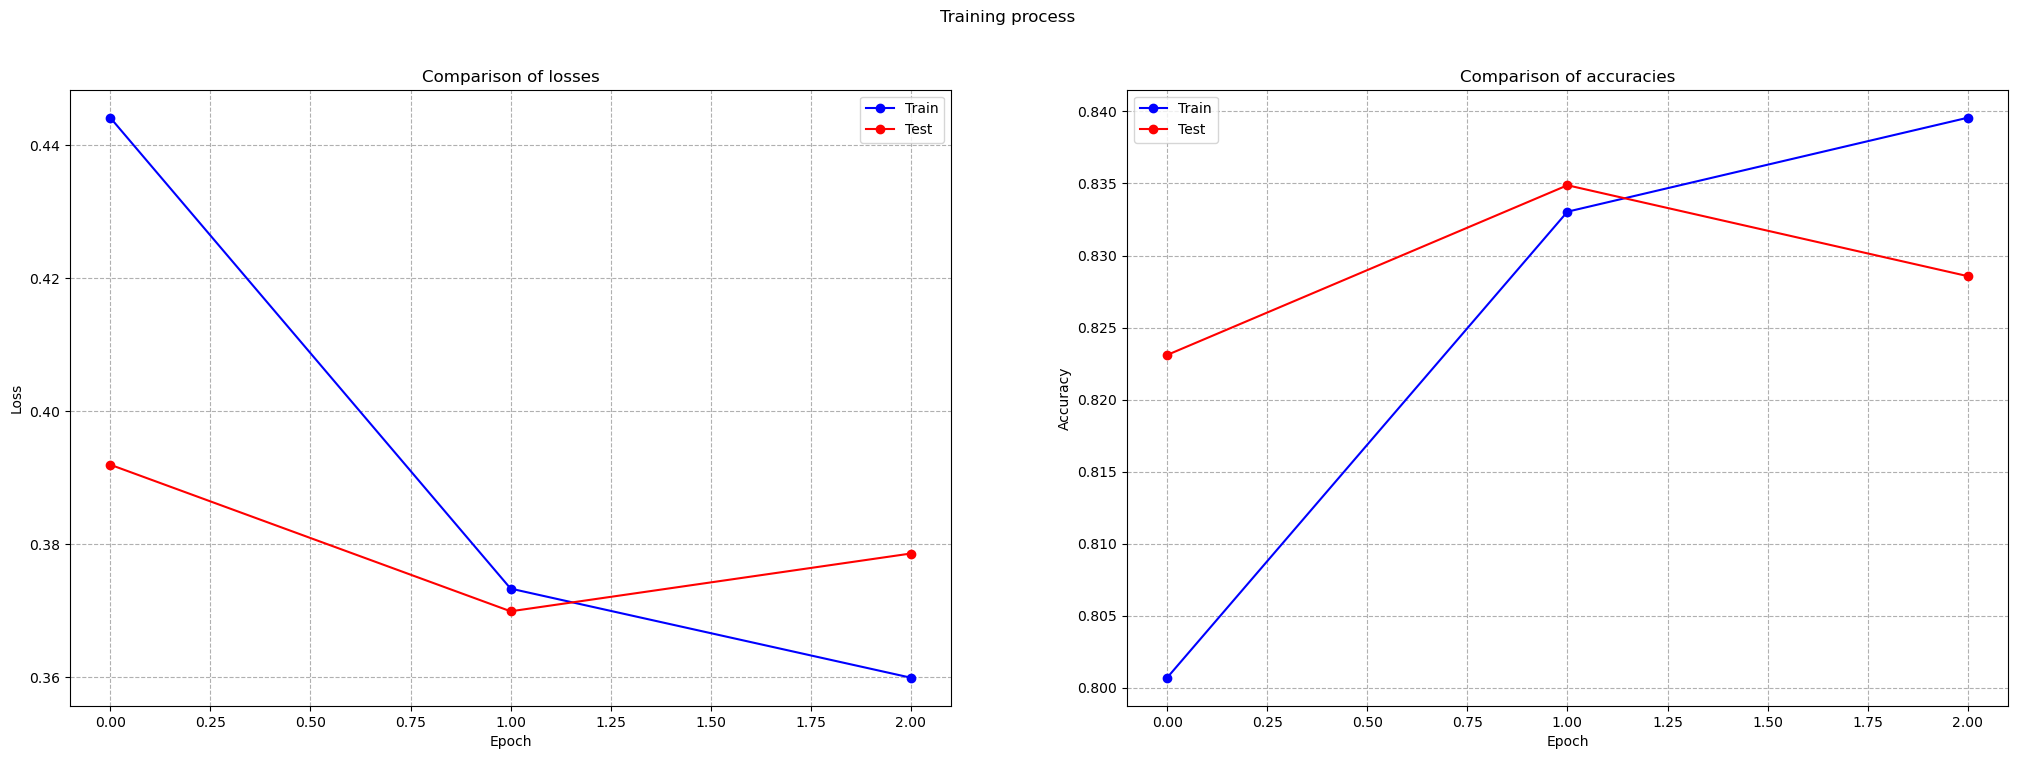

In [225]:
visualize(losses, accuracies)

In [227]:
print(f"Accuracy of sentiment-analysis pipeline based on ELMo embeddings is {accuracies['test'][-1] * 100:.2f}%")

Accuracy of sentiment-analysis pipeline based on ELMo embeddings is 82.86%


## Compare the results with BERT embeddings

Hugging face package includes pipelines for various NLP tasks including sentiment analysis. In this sections let's use it to classify IMDB movie reviews.

In [228]:
model = "distilbert-base-uncased-finetuned-sst-2-english"
x_test_truncated = [_[:512] for _ in list(x_test)]
model = pipeline("sentiment-analysis", model=model, device=0)
y_pred = model(x_test_truncated)
result = [int(_['label'] != 'NEGATIVE') for _ in y_pred]

In [229]:
accuracy = accuracy_score(y_test, result)
print(f"Accuracy of sentiment-analysis pipeline based on BERT embeddings is {accuracy * 100:.2f}%")

Accuracy of sentiment-analysis pipeline based on BERT embeddings is 78.67%


Wow! Accuracy of pre-trained BERT is less than for ELMo embeddings 🥳